# Tau PT Regression Notebook

In this notebook we will implement a NN to regress the tau's transverse momentum.

In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/pt_regress_v1.h5'

2023-06-26 14:59:10.190632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 14:59:10.315536: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-26 14:59:10.320143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-26 14:59:10.320157: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [2]:
# #You only need to run this once
# def create_training_data(dir_path, test_index=400000):
#     '''
#     test_index: 400000 
#     All the data before test_index are used for training. And all the data after it is used for testing.
#     '''
    
#     #Might have to change the version for other ntuple files
#     data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    
#     inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#     print(inputs)
#     truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[:test_index]
#     reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#     eta = data['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#     selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_train = np.nan_to_num(np.asarray(inputs[selection]))
#     y_train = np.asarray(truth_pt[selection]/reco_pt[selection])
    
#     X_train[abs(X_train) > 1e+9] = 0.

#     np.save(dir_path+"/X_train.npy", X_train)
#     np.save(dir_path+"/y_train.npy", y_train)

In [3]:
# create_training_data("../../ntuples/Jan_25_2023")

In [4]:
# X_train = np.load("../../ntuples/Jan_25_2023/X_train.npy")
# y_train = np.load("../../ntuples/Jan_25_2023/y_train.npy")
# print(X_train.shape[1:])
# print(len(y_train))

In [5]:
# def create_train_test_data(dir_path, test_index=400000, train = True):
        
#     #Might have to change the version for other ntuple files
#     sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
#     qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
#     if train:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     else:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
#     selection_bkg = reco_pt_bkg > 20.
#     y_bkg_pT = truth_pt_bkg[selection_bkg]
#     print("b")
#     print(len(y_bkg_pT))
#     reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
#     selection_qcd = reco_pt_qcd > 20.
#     y_qcd_pT = truth_pt_qcd[selection_qcd]
        
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
#     y_sig = np.full(X_sig.shape[0], 1.)
#     sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
#     X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
#     y_bkg = np.full(X_bkg.shape[0], 0.)
#     bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
#     X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
#     y_qcd = np.full(X_qcd.shape[0], 0.)
#     qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
#     background_pt = np.concatenate([bkg_pt, qcd_pt])
#     print(y_sig, y_bkg, y_qcd)
#     X_train = np.concatenate([X_sig, X_bkg, X_qcd])
#     y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
#     MinBias_pT_1 = [1 for i in y_bkg_pT]
#     print(MinBias_pT_1)
#     qcd_pT_1 = [1 for i in y_qcd_pT]
# #     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
#     pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
#     X_train[abs(X_train) > 1e+4] = 0.
    
#     assert not np.any(np.isnan(X_train))
#     assert not np.any(np.isnan(y_train_jetID))
#     assert not np.any(np.isnan(y_train_pT))
    
#     return X_train, y_train_jetID, y_train_pT

# X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
# X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
# X_train = X_train_jetID
# y_train = y_train_pT_regress
# X_test = X_test_jetID
# y_test = y_test_pT_regress
# print(X_train_jetID)
# print(len(y_train_pT_regress))

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.0
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.0
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 25)                2025      
                                                                 
 dense_211 (Dense)           (None, 25)                650       
                                                                 
 dense_212 (Dense)           (None, 15)                390       
                                                                 
 dense_213 (Dense)           (None, 15)                240       
                                                                 
 dense_214 (Dense)           (None, 10)                160       
                                                                 
 dense_215 (Dense)           (Non

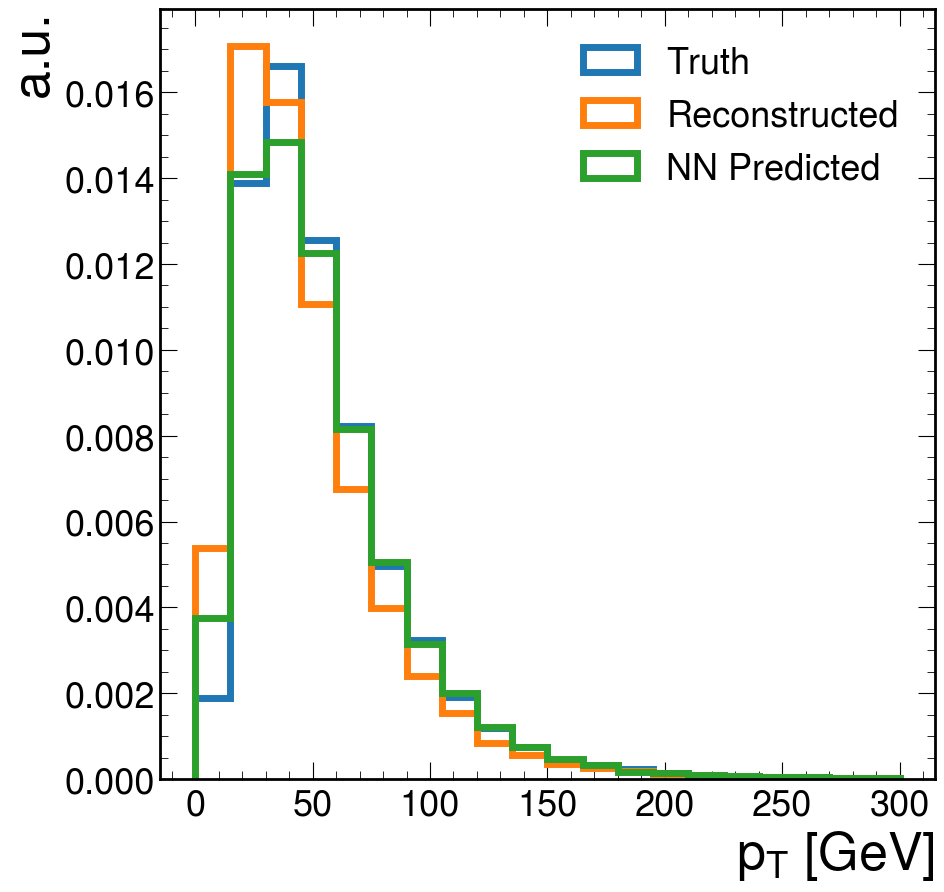

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.1
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.1
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 25)                2025      
                                                                 
 dense_217 (Dense)           (None, 25)                650       
                                                                 
 dense_218 (Dense)           (None, 15)                390       
                                                                 
 dense_219 (Dense)           (None, 15)                240       
                                                                 
 dense_220 (Dense)           (None, 10)                160       
                                                                 
 dense_221 (Dense)           (Non

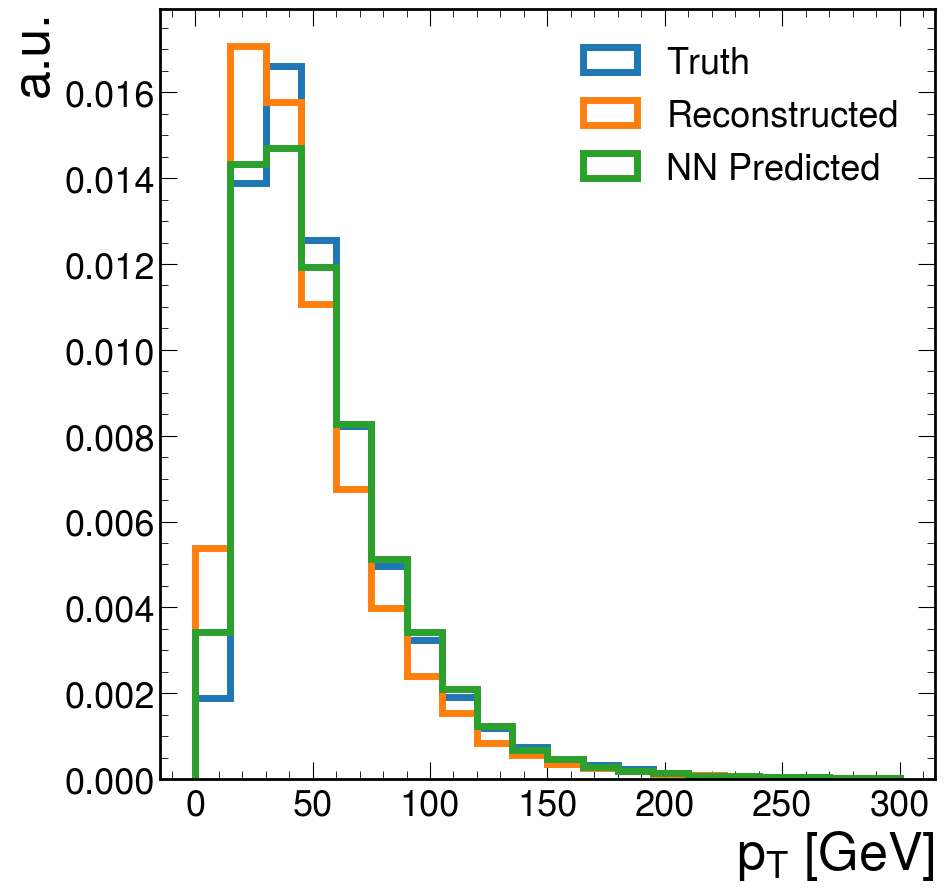

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.2
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.2
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 25)                2025      
                                                                 
 dense_223 (Dense)           (None, 25)                650       
                                                                 
 dense_224 (Dense)           (None, 15)                390       
                                                                 
 dense_225 (Dense)           (None, 15)                240       
                                                                 
 dense_226 (Dense)           (None, 10)                160       
                                                                 
 dense_227 (Dense)           (Non

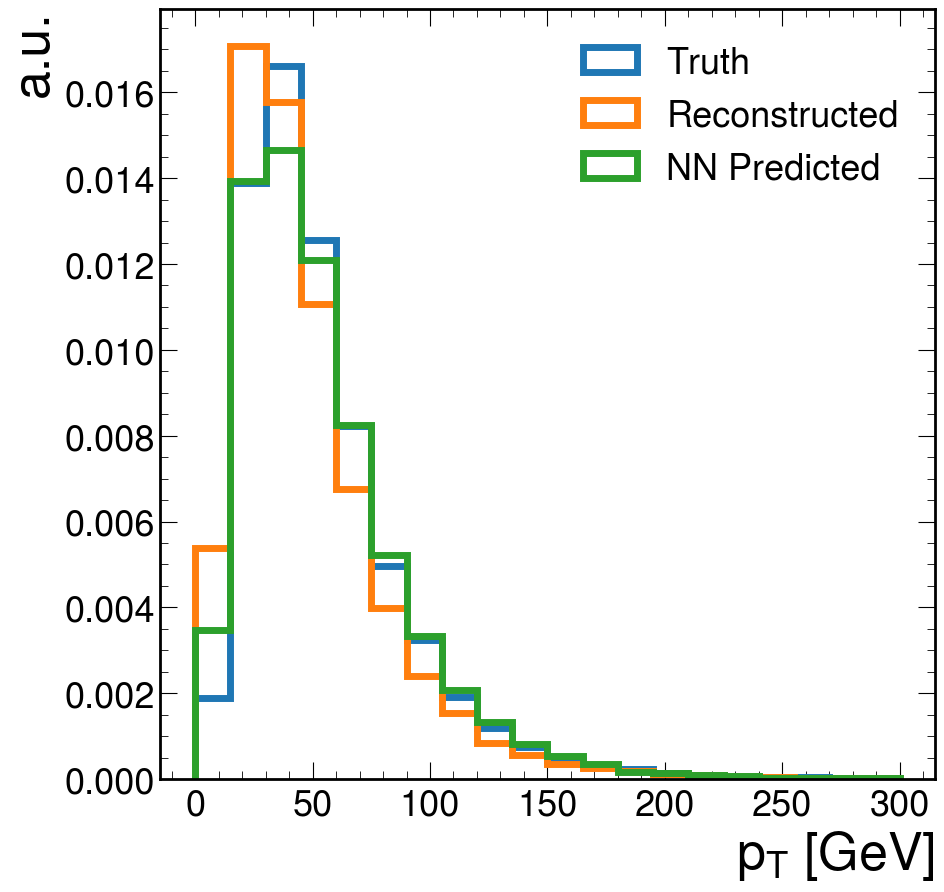

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.3
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.3
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 25)                2025      
                                                                 
 dense_229 (Dense)           (None, 25)                650       
                                                                 
 dense_230 (Dense)           (None, 15)                390       
                                                                 
 dense_231 (Dense)           (None, 15)                240       
                                                                 
 dense_232 (Dense)           (None, 10)                160       
                                                                 
 dense_233 (Dense)           (Non

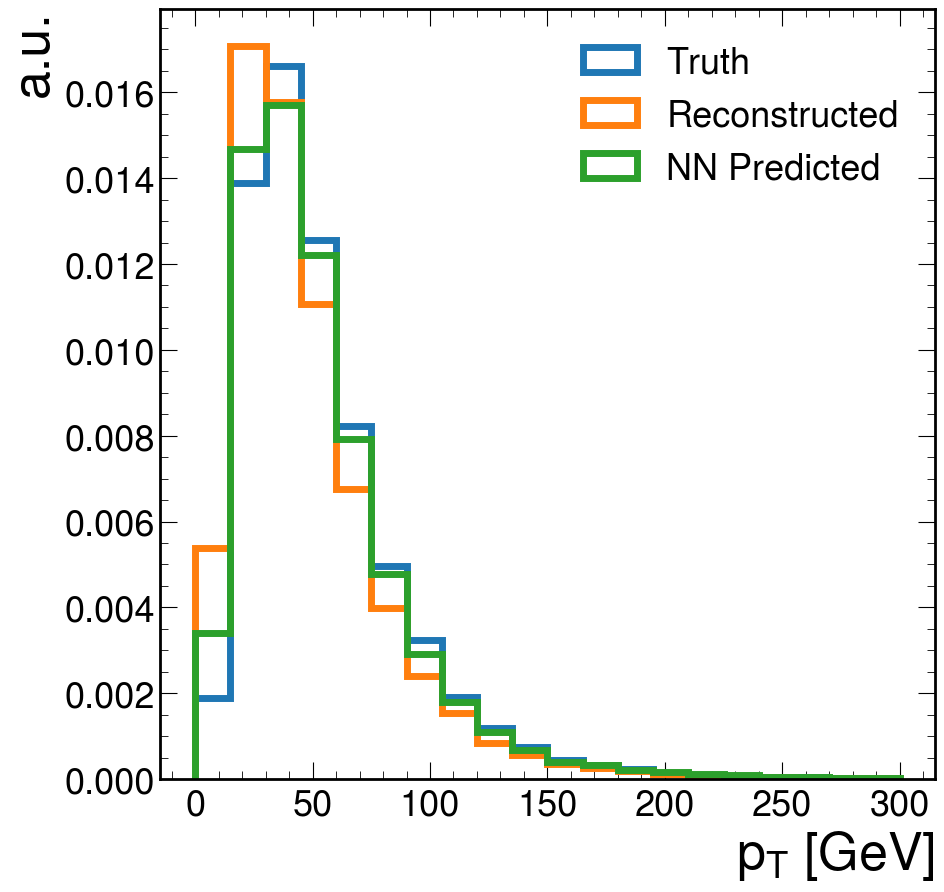

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.4
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.4
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_234 (Dense)           (None, 25)                2025      
                                                                 
 dense_235 (Dense)           (None, 25)                650       
                                                                 
 dense_236 (Dense)           (None, 15)                390       
                                                                 
 dense_237 (Dense)           (None, 15)                240       
                                                                 
 dense_238 (Dense)           (None, 10)                160       
                                                                 
 dense_239 (Dense)           (Non

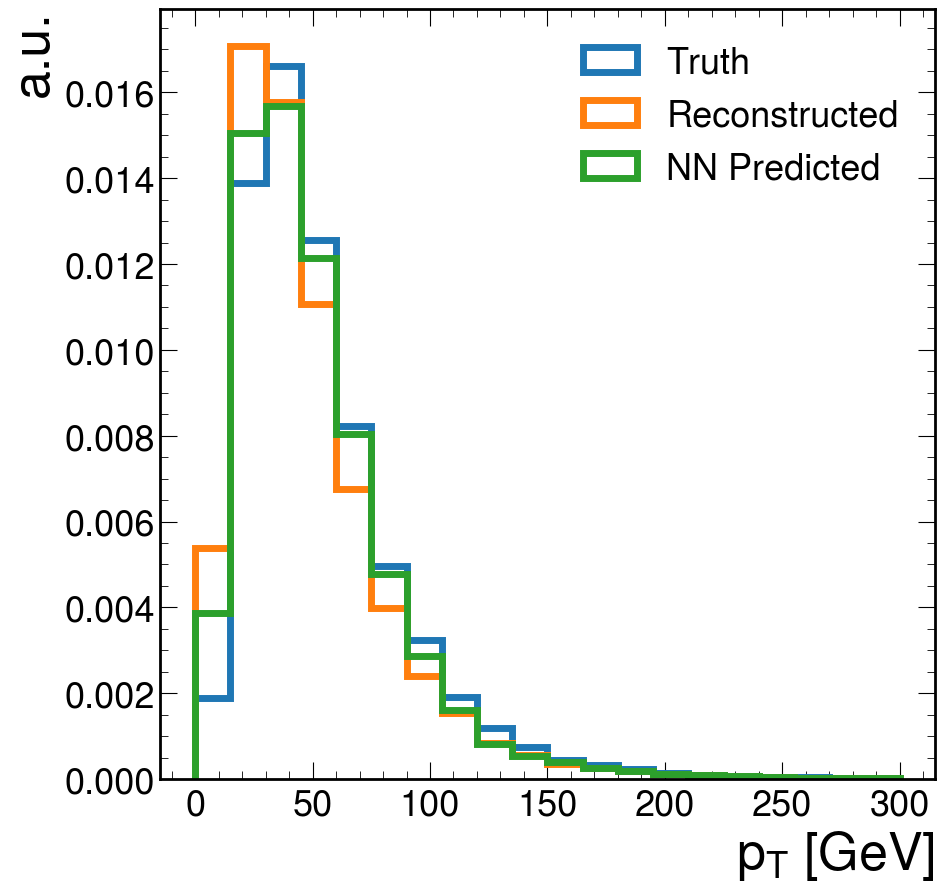

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.5
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.5
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 25)                2025      
                                                                 
 dense_241 (Dense)           (None, 25)                650       
                                                                 
 dense_242 (Dense)           (None, 15)                390       
                                                                 
 dense_243 (Dense)           (None, 15)                240       
                                                                 
 dense_244 (Dense)           (None, 10)                160       
                                                                 
 dense_245 (Dense)           (Non

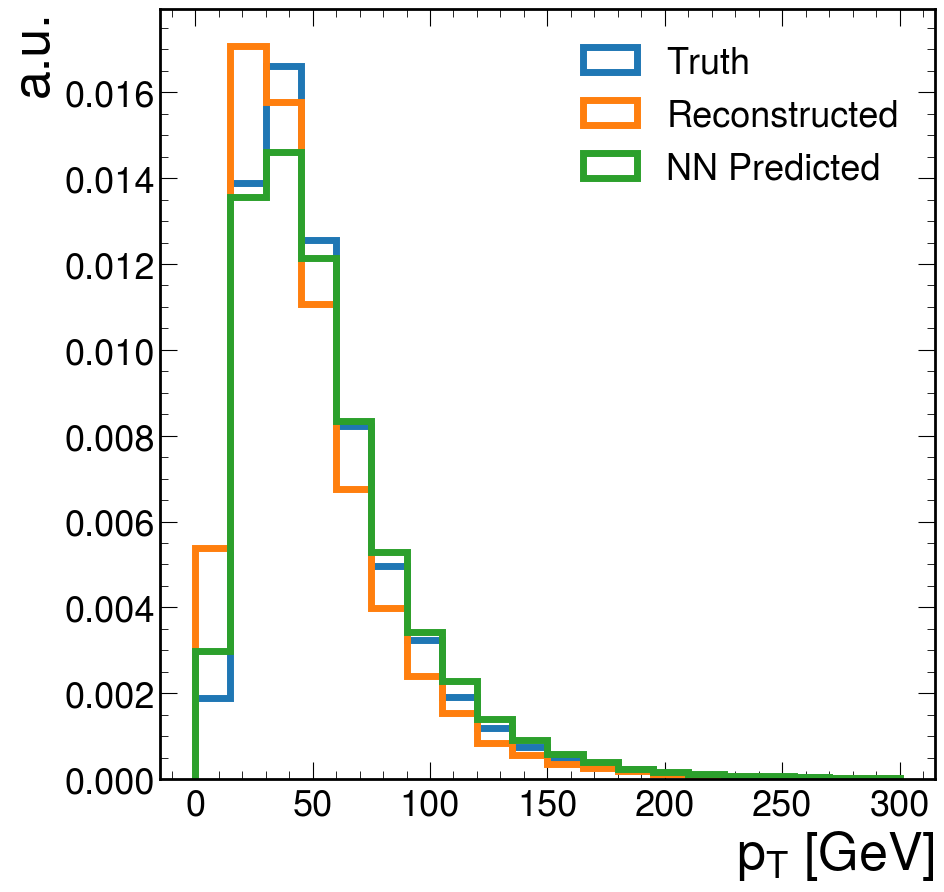

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.6
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.6
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 25)                2025      
                                                                 
 dense_247 (Dense)           (None, 25)                650       
                                                                 
 dense_248 (Dense)           (None, 15)                390       
                                                                 
 dense_249 (Dense)           (None, 15)                240       
                                                                 
 dense_250 (Dense)           (None, 10)                160       
                                                                 
 dense_251 (Dense)           (Non

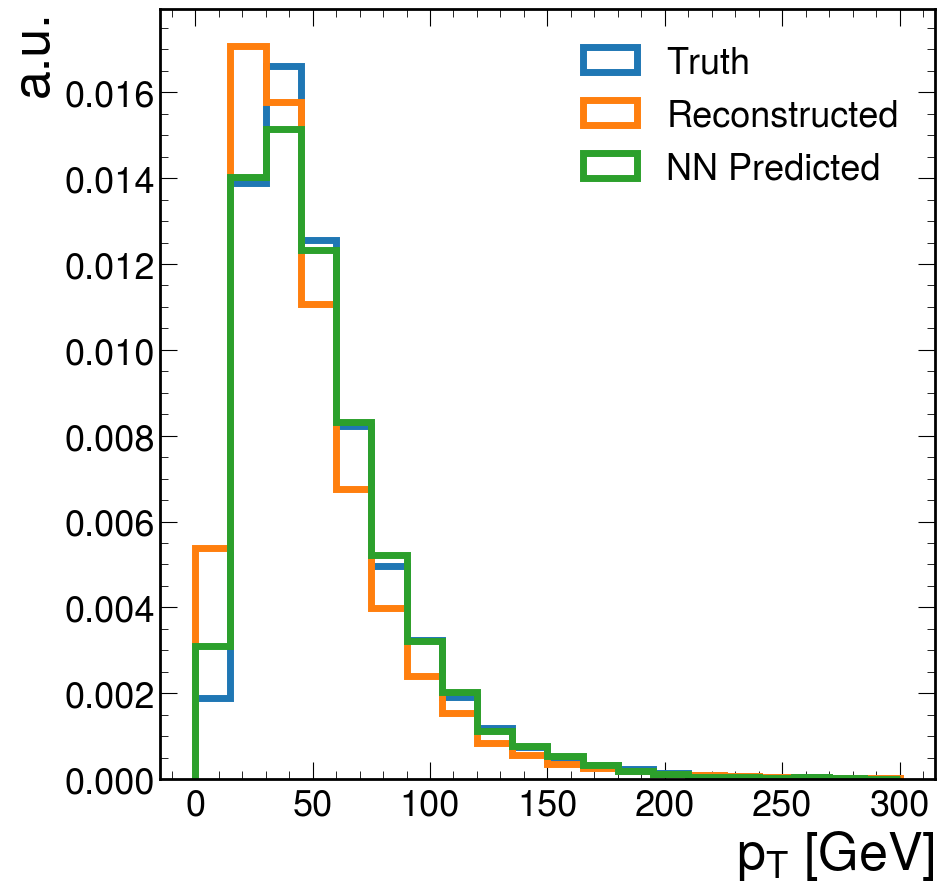

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.7
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.7
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 25)                2025      
                                                                 
 dense_253 (Dense)           (None, 25)                650       
                                                                 
 dense_254 (Dense)           (None, 15)                390       
                                                                 
 dense_255 (Dense)           (None, 15)                240       
                                                                 
 dense_256 (Dense)           (None, 10)                160       
                                                                 
 dense_257 (Dense)           (Non

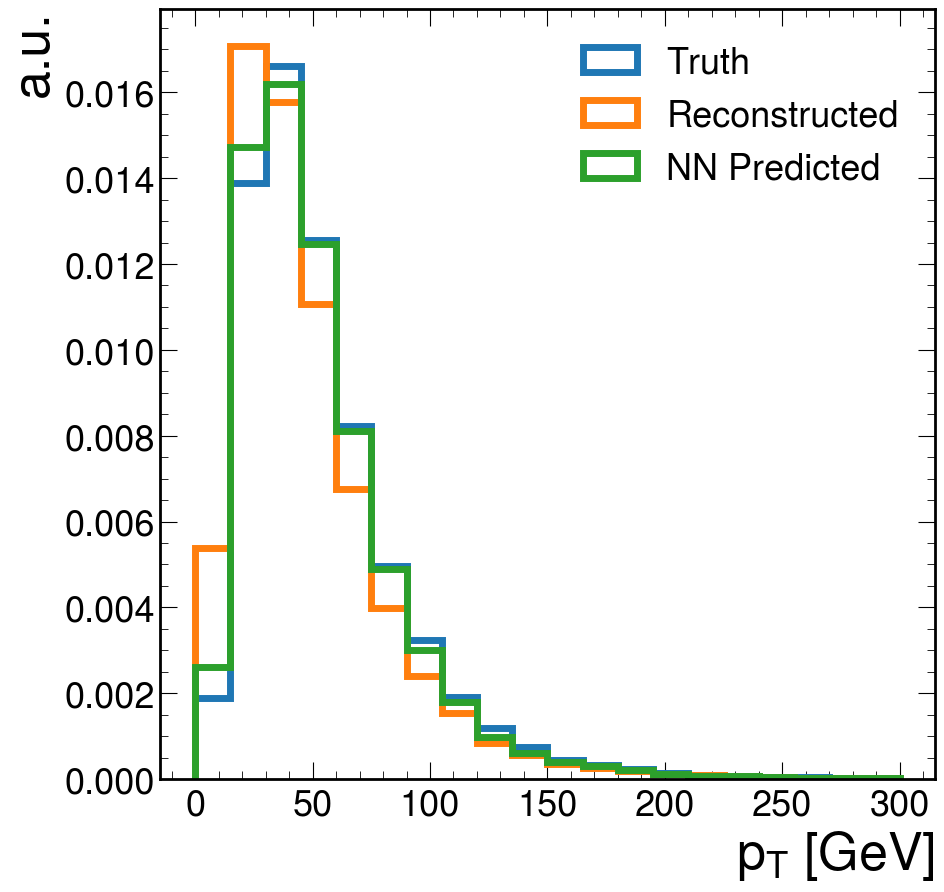

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.8
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.8
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_258 (Dense)           (None, 25)                2025      
                                                                 
 dense_259 (Dense)           (None, 25)                650       
                                                                 
 dense_260 (Dense)           (None, 15)                390       
                                                                 
 dense_261 (Dense)           (None, 15)                240       
                                                                 
 dense_262 (Dense)           (None, 10)                160       
                                                                 
 dense_263 (Dense)           (Non

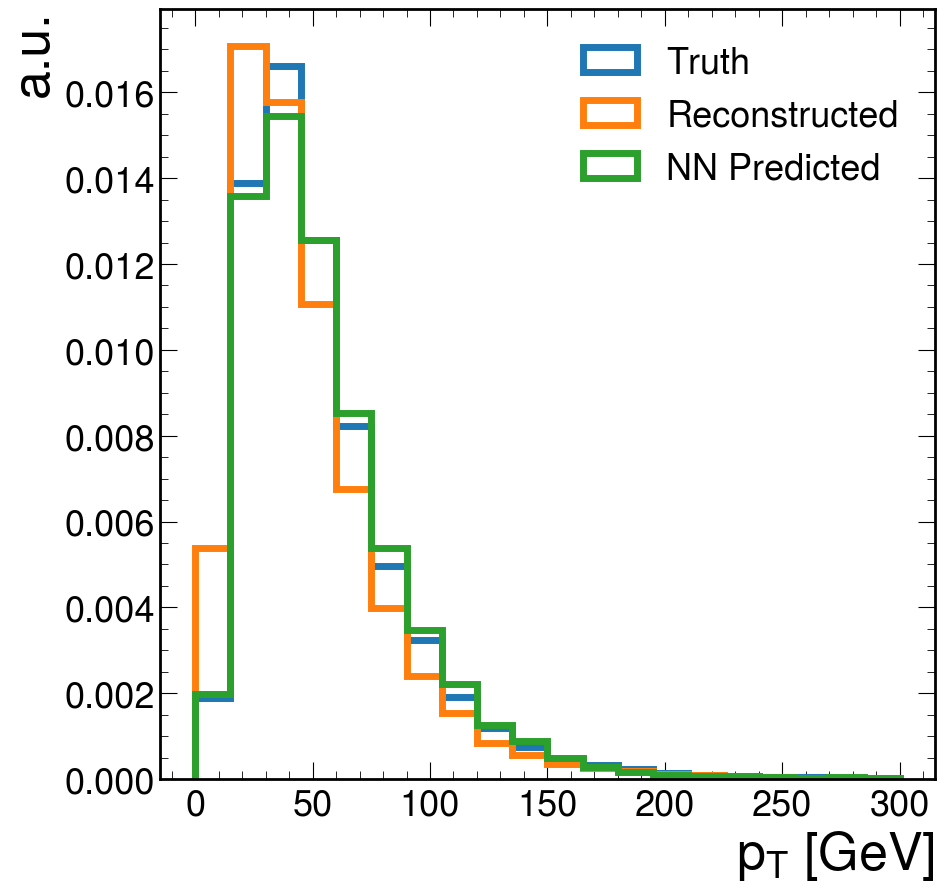

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.9
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
0.9
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 25)                2025      
                                                                 
 dense_265 (Dense)           (None, 25)                650       
                                                                 
 dense_266 (Dense)           (None, 15)                390       
                                                                 
 dense_267 (Dense)           (None, 15)                240       
                                                                 
 dense_268 (Dense)           (None, 10)                160       
                                                                 
 dense_269 (Dense)           (Non

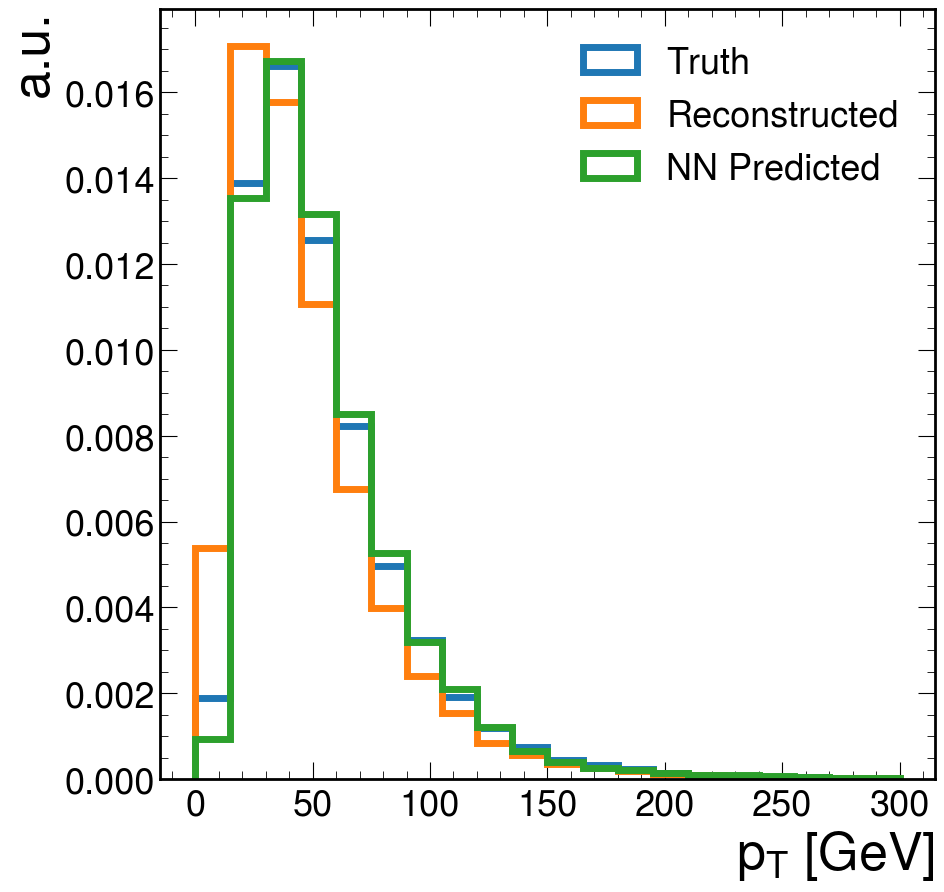

In [9]:
# lower the number of injections of MinBias to get rid of the bias torwards lower pT predictions

import random
for test in range(10):
    def create_train_test_data(dir_path, test_index=400000, train = True):

        #Might have to change the version for other ntuple files
        sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
        bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
        qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")

        if train:
            sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
            bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
            qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

            truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
            truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
            truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

            reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
            deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
            eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
            selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
            y_sig_pT = truth_pt_sig[selection_sig]

            reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        else:
            sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
            bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
            qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

            truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
            truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
            truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
            reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
            deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
            eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
            selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
            y_sig_pT = truth_pt_sig[selection_sig]

            reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]

        selection_bkg = reco_pt_bkg > 10
        y_bkg_pT = truth_pt_bkg[selection_bkg]
        reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
        selection_qcd = reco_pt_qcd > 10
        y_qcd_pT = truth_pt_qcd[selection_qcd]

        #Inputs: pt, eta, phi, particle id(one hot encoded)
        X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
        y_sig = np.full(X_sig.shape[0], 1.)
        sig_pt = np.asarray(reco_pt_sig[selection_sig])

        X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
        y_bkg = np.full(X_bkg.shape[0], 0.)
        bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])

        X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
        y_qcd = np.full(X_qcd.shape[0], 0.)
        qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])

        background_pt = np.concatenate([bkg_pt, qcd_pt])

        print(y_sig, y_bkg, y_qcd)
        
        print(test/10)
        if train:
            X_bkg = list(X_bkg)
            y_bkg = list(y_bkg)
            y_bkg_pT = list(y_bkg_pT)
            percent = 0 + test/10
            for _ in range(int(percent*len(X_bkg))):
                n = len(X_bkg)
                random_ind = random.randint(0, n - 1)
                del X_bkg[random_ind]
                del y_bkg[random_ind]
                del y_bkg_pT[random_ind]
            X_bkg = np.asarray(X_bkg)
            y_bkg = np.asarray(y_bkg)
            y_bkg_pT = np.asarray(y_bkg_pT)

            X_qcd = list(X_qcd)
            y_qcd = list(y_qcd)
            y_qcd_pT = list(y_qcd_pT)
            for _ in range(int(percent*len(X_qcd))):
                n = len(X_qcd)
                random_ind = random.randint(0, n - 1)
                del X_qcd[random_ind]
                del y_qcd[random_ind]
                del y_qcd_pT[random_ind]
            X_qcd = np.asarray(X_qcd)
            y_qcd = np.asarray(y_qcd)
            y_qcd_pT = np.asarray(y_qcd_pT)

        X_train = np.concatenate([X_sig, X_bkg, X_qcd])
        y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
        MinBias_pT_1 = [1 for i in y_bkg_pT]
        qcd_pT_1 = [1 for i in y_qcd_pT]
    #     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
        y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
        pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])

        X_train[abs(X_train) > 1e+4] = 0.

        assert not np.any(np.isnan(X_train))
        assert not np.any(np.isnan(y_train_jetID))
        assert not np.any(np.isnan(y_train_pT))

        return X_train, y_train_jetID, y_train_pT

    X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
    X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
    X_train = X_train_jetID
    y_train = y_train_pT_regress
    X_test = X_test_jetID
    y_test = y_test_pT_regress


    # inputs = tf.keras.layers.Input(shape=(80,), name='input')
    # inputs = tf.expand_dims(inputs, axis=-1)

    # main_branch = tf.keras.layers.Conv1D(25, kernel_size = 5)(inputs)
    # main_branch = tf.keras.layers.Dense(25, activation = "LeakyReLU")(main_branch)
    # main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
    # main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
    # main_branch = tf.keras.layers.Dense(10, activation = "LeakyReLU")(main_branch)


    # output_branch = tf.keras.layers.Dense(1, name='pT_output')(main_branch)

    # model = tf.keras.Model(inputs = inputs, outputs = output_branch)



    model = Sequential()

    model.add(tf.keras.Input(shape=(80,)))

    #model.add(Conv1D(32, kernel_size = 5))


    model.add(Dense(25,
                    #input_shape=(X_train.shape[1:]),
                    activation= 'LeakyReLU'))

    model.add(Dense(25,
                    #input_shape=X_train.shape[1:],
                    activation= 'LeakyReLU'))
    model.add(Dense(15,
                    #input_shape=X_train.shape[1:],
                    activation= 'LeakyReLU'))

    model.add(Dense(15,
                    #input_shape=X_train.shape[1:],
                    activation= 'LeakyReLU'))

    model.add(Dense(10,
                    #input_shape=X_train.shape[1:],
                    activation= 'LeakyReLU'))

    model.add(Dense(1))


    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='mean_squared_error')
    model.summary()

    #Train the network
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

    history = model.fit(X_train, y_train,
                        epochs=30,
                        batch_size=256,
                        verbose=2,
                        validation_split=0.2, 
                        callbacks = [callback])

    #Save the model
    model.save(model_name)

    def load_and_predict_test(dir_path, model, test_index=400000):

        #Might have to change the version for other ntuple files
        data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
        inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]

        truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
        reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

        selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)

        truth_pt_selected = np.asarray(truth_pt[selection])
        reco_pt_selected = np.asarray(reco_pt[selection])

        X_test = np.asarray(inputs[selection])
        y_pred = model.predict(X_test).flatten()
        pred_pt = np.multiply(reco_pt_selected, y_pred)

        #Plot the pts
        truth_height, temp_truth, temp_truth_again = plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
        plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
        pred_height, temp_pred, temp_pred_again = plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)
        
        print(truth_height)
        print(pred_height)
        
        total_residue = 0
        for i in range(len(pred_height)):
            total_residue =+ abs(truth_height[i] - pred_height[i])
        print("total residue: " + str(total_residue))
        
        plt.xlabel(r'$p_T$ [GeV]')
        plt.ylabel('a.u.')
        plt.legend()  
        plt.show()

    load_and_predict_test("../../ntuples/Jan_25_2023", model)

    def bob(dir_path, model, test_index=400000):

        #Might have to change the version for other ntuple files
        data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
        inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]

        truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
        reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

        selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)

        truth_pt_selected = np.asarray(truth_pt[selection])
        reco_pt_selected = np.asarray(reco_pt[selection])

        X_test = np.asarray(inputs[selection])
        y_pred = model.predict(X_test).flatten()
        pred_pt = np.multiply(reco_pt_selected, y_pred)

        residual = pred_pt - truth_pt_selected
        print(min(residual))
        print(max(residual))
        plot_bins = 200
        plot_range = (-125, 75)
        p_guess=[10, 0, 0.01]
        plt.hist(residual,
             bins = plot_bins,
             range = plot_range,
             density = True)
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

        data_entries, _ = np.histogram(residual, bins=bins,
                                       range = plot_range,
                                       density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False)

        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]

        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)

        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 label='Best fit')

        plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))

        plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
        plt.ylabel('Normalized counts')

        plt.legend()

    #bob("../../ntuples/Jan_25_2023", model)

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

In [30]:
NormalModel = load_model('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5')
    
y_pred_mono = model(X_test)
fpr_mono, tpr_mono, _ = roc_curve(y_test_jetID, y_pred_mono)
auc_score_mono = round(auc(fpr_mono, tpr_mono),2)

y_pred_normal = NormalModel.predict(X_test)
fpr_normal, tpr_normal, _ = roc_curve(y_test_jetID,y_pred_normal)
auc_score_normal = round(auc(fpr_normal, tpr_normal),2)

11371/11371 [==============================] - 6s 496us/step


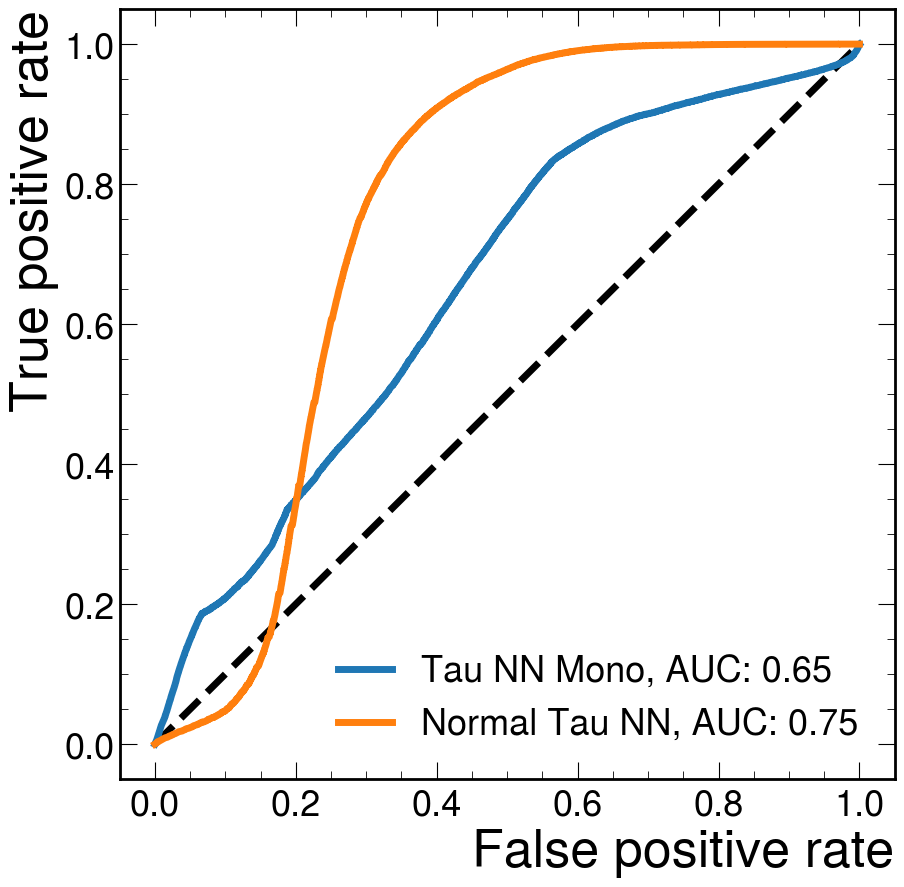

In [31]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_mono, tpr_mono, label = 'Tau NN Mono, AUC: {}'.format(auc_score_mono))
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau NN, AUC: {}'.format(auc_score_normal))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()